In [36]:
#ML4VA project Predicting Police Response times code. 
#By Aidan Sinclair, Andrei Stan, and Cameron Dorsch 


#So we want to get CallTime and find difference between OnSceneDate/Time to calculate the responsiveness time. 
#We train on dataSetTwo which has the Zone, priority, and CallTime as columns.
#DataSet is the original data that is maintained be used as a reference when necessary. 

import pandas as pd
import numpy as np

#get the data prices in link to raw data on my github
url = 'https://raw.githubusercontent.com/adssoccer1/machineLearning2019/master/Police_Calls_for_Service1.csv'
names = ['CallType', 'Zone', 'CaseDisposition', 'priority', 'CallTime', 'EntryDate/Time', 'DispatchDate/Time', 'EnRouteDate/Time', 'OnSceneDate/Time']
dataSet = pd.read_csv(url, names=names)


#drop uneeded columns
dataSetTwo = dataSet.drop("CallType", axis=1)
dataSetTwo = dataSetTwo.drop("CaseDisposition", axis=1)
dataSetTwo = dataSetTwo.drop("EntryDate/Time", axis=1)
dataSetTwo = dataSetTwo.drop("DispatchDate/Time", axis=1)
dataSetTwo = dataSetTwo.drop("EnRouteDate/Time", axis=1)
dataSetTwo = dataSetTwo.drop("OnSceneDate/Time", axis=1)

#Helper Function: 
def get_sec(time_str):
    """Get Seconds from time."""
    counter = 0
    for x in time_str:
      if x == ":":
        counter += 1
    if counter == 2:
      h, m, s = time_str.split(':')
      return int(h) * 3600 + int(m) * 60 + int(s)
    elif counter == 1:
      h, m = time_str.split(':')
      return int(h) * 3600 + int(m) * 60
    else: 
      m = time_str
      return int(m) * 60

#Helper Function     
def getAverage(newReponseTime):
  sum = 0 
  counter = 0
  for seconds in newResponseTime:
    if seconds > 0:
      sum += seconds
      counter += 1
  return sum / counter
    
#get a list of calltime converted to seconds
CallTime = dataSet["CallTime"].copy()
CallTimeList = [] #list of call times. 
for instance in CallTime:
  if type(instance) is float: 
    CallTimeList.append(-1111)
  else:
    splitInstance = instance.split()
    time = splitInstance[1]
    time = get_sec(time)#using the helper function
    CallTimeList.append(time) 
#print("CallTimeList: ",CallTimeList[0:9])

#get a list of on scene time converted to seconds
OnSceneTime = dataSet["OnSceneDate/Time"].copy()
OnSceneTimeList = [] #list of arrival times. 
for instance in OnSceneTime:
  if type(instance) is float: 
    OnSceneTimeList.append(-1111)
  else:
    splitInstance = instance.split()
    time = splitInstance[1]
    time = get_sec(time)#using the helper function
    OnSceneTimeList.append(time)
#print(OnSceneTimeList[0:9])


#Now we do subtraction of the two columns convereted to seconds above and make new array with response time in seconds:

#get new responseTime list by subracting time called(in CallTimeList) vs time of arrival(in OnSceneTimeList) 
responseTime = []
for index in range(len(CallTimeList)):
  temp = OnSceneTimeList[index] - CallTimeList[index]
  if OnSceneTimeList[index] == -1111 or CallTimeList[index] == -1111:
    responseTime.append(-1111)
  elif temp < 0: 
    responseTime.append(-1111)
  else: 
    responseTime.append(OnSceneTimeList[index] - CallTimeList[index])

"""
Now get rid of outliers before inserting the average into null instances. So in our original dataset we had 16428 calls that 
had response times of over and hour, out of a total of 182367 instances, so we decided to model just calls that took 
under an hour. We will also remove instances that take 0 seconds in response time. 
"""
#go through the list of calulated response times: 
sum = 0; 
indexToBeRemovedArray = [] #array to keep track of which instances are over 3600 seconds in response time.
newResponseTime = [] #array to hold response times we want to keep 
for instance in range(len(responseTime)):
  if responseTime[instance] > 3600:
    indexToBeRemovedArray.append(instance)
  #elif responseTime[instance] == 0:
  #  indexToBeRemovedArray.append(instance)
  else:
    newResponseTime.append(responseTime[instance])

#Now impute missing values with the average.
#For every -1111 or negative number we put into responseTime we need to replace with the average of all the other responseTime enteries
#so go through the response times and impute missing values with the average response time. 
average = getAverage(newResponseTime)#using the helper function
print(average, " average that was imputed into mussing values")
for index in range(len(newResponseTime)):
  if newResponseTime[index] <= 0:
    newResponseTime[index] = average
#print(newResponseTime[0:19])

#prepare DataSetTwo
dataSetTwo["CallTime"] = CallTimeList
#print(len(dataSetTwo))

#now we get rid of the > 3600 second instances
dataSetTwo = dataSetTwo.drop(indexToBeRemovedArray, axis=0)








962.0974004363421  average that was imputed into mussing values


We can see priority is a relatively strong correlator to ResponseTime
                  Zone  priority  CallTime  responseTime
Zone          1.000000  0.101746  0.001573      0.076392
priority      0.101746  1.000000  0.001168      0.181080
CallTime      0.001573  0.001168  1.000000      0.005065
responseTime  0.076392  0.181080  0.005065      1.000000

DataSet info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 165939 entries, 0 to 182366
Data columns (total 4 columns):
Zone            165939 non-null int64
priority        165939 non-null int64
CallTime        165939 non-null int64
responseTime    165939 non-null float64
dtypes: float64(1), int64(3)
memory usage: 6.3 MB
None

The solid in line in second graph is due to importing average values for missing values.


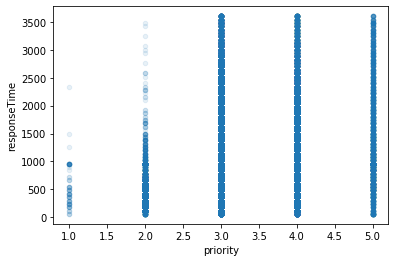

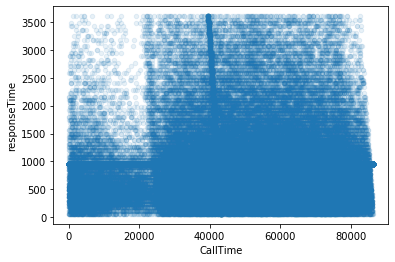

In [30]:
#add response time to the dataSetTwo
df = pd.DataFrame(dataSetTwo)
#print(len(dataSetTwo))
df["responseTime"] = newResponseTime

#some data vizualization 
print("We can see priority is a relatively strong correlator to ResponseTime")
corr_matrix = dataSetTwo.corr()
print(corr_matrix)

#info about dataset
print("")
print("DataSet info:")
print(dataSetTwo.info())
print("")


#also use scatter plot of priority and responseTime.
print("The solid in line in second graph is due to importing average values for missing values.")
dataSetTwo.plot(kind="scatter", x="priority", y="responseTime", alpha=0.1)
dataSetTwo.plot(kind="scatter", x="CallTime", y="responseTime", alpha=0.1)




In [35]:
print("(1) RESULT OF THE FIRST EXPERIMENT BELOW: The following linear regression, decision tree, and random forest model (bellow) are the results we recieved \n",
      "on one of our first models. These models were trained on the dataset with no outlier removal or imputing missing \n",
      "values with averages. These were basically our baseline models and the best error rate we got was around 5700 seconds \n ",
      "or about 95 minutes which would not be useful infromation in the case of an emergency. This was achieved using a linear \n", 
      "regression model. However, the later models greatly improve upon this accuracy")

(1) RESULT OF THE FIRST EXPERIMENT BELOW: The following linear regression, decision tree, and random forest model (bellow) are the results we recieved 
 on one of our first models. These models were trained on the dataset with no outlier removal or imputing missing 
 values with averages. These were basically our baseline models and the best error rate we got was around 5700 seconds 
  or about 95 minutes which would not be useful infromation in the case of an emergency. This was achieved using a linear 
 regression model. However, the later models greatly improve upon this accuracy


In [17]:
from sklearn.model_selection import train_test_split
import numpy as np

#helper function 
def display_scores(scores):
    print("Cross validation Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std(), "\n")


#test validity of dataSetTwo - we should return false and true
#print(np.any(np.isnan(dataSetTwo)))
#print(np.all(np.isfinite(dataSetTwo)))

#split dataSetTwo and responseTime to prepare for standard scaling and train_test_split
responseTime = dataSetTwo["responseTime"].copy()
dataSetTwo = dataSetTwo.drop("responseTime", axis=1)

#standard scaling the values from dataSet (columns Zone, priority, and CallTime )
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dataSetTwo)
StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.mean_
dataSetTwo = scaler.transform(dataSetTwo)

#check the dataSet looks okay
#print(dataSetTwo)

#split dataSetTwo  after using standard scalar 
X_train, X_test, y_train, y_test = train_test_split(dataSetTwo, responseTime, test_size=0.2, random_state=42)

#train a linear regression model and print results
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
print("LINEAR REGRESSION")
print("mean squared error: " , lin_mse)
lin_rmse = np.sqrt(lin_mse)
print("root mean squared error: " , lin_rmse)
lin_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , lin_mae, "\n")
#cross validation on the linear regression model
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


#train a decision tree model and print results
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred)
print("DECISION TREE")
print("mean squared error: " , tree_mse)
tree_rmse = np.sqrt(tree_mse)
print("root mean squared error: " , tree_rmse)
tree_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , tree_mae, "\n")
#cross validation on the decision tree model
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)


#train a random forest model and print results
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_pred)
print("RANDOM FOREST")
print("mean squared error: " , forest_mse)
forest_rmse = np.sqrt(forest_mse)
print("root mean squared error: " , forest_rmse)
forest_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , forest_mae, "\n")
#cross validation on the random forest model
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

LINEAR REGRESSION
mean squared error:  26361272.997375987
root mean squared error:  5134.323032043853
mean absolute error:  2751.549339324235 

Cross validation Scores: [5141.21938577 5220.28534534 5276.78032238 5141.17855766 5159.32748132
 5061.35096915 4903.52678104 5201.88211449 5288.78461274 5320.55112627]
Mean: 5171.48866961791
Standard deviation: 116.74154238157955 

DECISION TREE
mean squared error:  38866264.30180116
root mean squared error:  6234.281378138234
mean absolute error:  2744.6526890078026 

Cross validation Scores: [6267.12284733 6280.65829041 6190.63475616 6194.31139645 6332.4940888
 6267.68224441 6021.18023754 6386.14059835 6271.61457149 6357.25011676]
Mean: 6256.9089147700115
Standard deviation: 98.67203468713718 

RANDOM FOREST
mean squared error:  29137116.75353708
root mean squared error:  5397.880765035208
mean absolute error:  2598.6483128633877 

Cross validation Scores: [5430.01396514 5513.9312211  5352.7325824  5320.52902136 5459.4095391
 5396.45954672 52

In [34]:
print("(3) RESULT OF THE THIRD EXPERIMENT BELOW: The following linear regression, decision tree, and random forest model (below) produce our best accuracies \n",
      "In particular the linear regression model gets a root mean squared error of 520 seconds or abour 8 minutes \n", 
      "and a mean absolute error of only 312 seconds or abour 5 minutes. This is a significant improvement from \n ",
      "the first few experiments we tried. See the experiments section on how we reduced our error rates.")

(3) RESULT OF THE THIRD EXPERIMENT BELOW: The following linear regression, decision tree, and random forest model (below) produce our best accuracies 
 In particular the linear regression model gets a root mean squared error of 520 seconds or abour 8 minutes 
 and a mean absolute error of only 312 seconds or abour 5 minutes. This is a significant improvement from 
  the first few experiments we tried. See the experiments section on how we reduced our error rates.


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

#helper function 
def display_scores(scores):
    print("Cross validation Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std(), "\n")


#test validity of dataSetTwo - we should return false and true
#print(np.any(np.isnan(dataSetTwo)))
#print(np.all(np.isfinite(dataSetTwo)))

#split dataSetTwo and responseTime to prepare for standard scaling and train_test_split
responseTime = dataSetTwo["responseTime"].copy()
dataSetTwo = dataSetTwo.drop("responseTime", axis=1)

#standard scaling the values from dataSet (columns Zone, priority, and CallTime )
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dataSetTwo)
StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.mean_
dataSetTwo = scaler.transform(dataSetTwo)

#check the dataSet looks okay
#print(dataSetTwo)

#split dataSetTwo  after using standard scalar 
X_train, X_test, y_train, y_test = train_test_split(dataSetTwo, responseTime, test_size=0.2, random_state=42)

#train a linear regression model and print results
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
print("LINEAR REGRESSION")
print("mean squared error: " , lin_mse)
lin_rmse = np.sqrt(lin_mse)
print("root mean squared error: " , lin_rmse)
lin_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , lin_mae, "\n")
#cross validation on the linear regression model
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


#train a decision tree model and print results
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred)
print("DECISION TREE")
print("mean squared error: " , tree_mse)
tree_rmse = np.sqrt(tree_mse)
print("root mean squared error: " , tree_rmse)
tree_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , tree_mae, "\n")
#cross validation on the decision tree model
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)


#train a random forest model and print results
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_pred)
print("RANDOM FOREST")
print("mean squared error: " , forest_mse)
forest_rmse = np.sqrt(forest_mse)
print("root mean squared error: " , forest_rmse)
forest_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , forest_mae, "\n")
#cross validation on the random forest model
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

LINEAR REGRESSION
mean squared error:  273106.9805200263
root mean squared error:  522.5963839523063
mean absolute error:  312.0393250951693 

Cross validation Scores: [520.99691681 520.14096455 511.80424308 520.00380467 516.49602802
 521.84739979 522.35087645 524.10368297 528.77788017 524.2933217 ]
Mean: 521.0815118200268
Standard deviation: 4.359229438172015 

DECISION TREE
mean squared error:  425480.1962807829
root mean squared error:  652.2884302827875
mean absolute error:  408.69056345765057 

Cross validation Scores: [657.25292252 657.02203485 652.21028549 649.62339987 651.11444696
 651.83645347 647.54567935 651.47951284 665.41964651 651.89505719]
Mean: 653.5399439044143
Standard deviation: 4.856057674288887 

RANDOM FOREST
mean squared error:  326827.65542992775
root mean squared error:  571.6884251320187
mean absolute error:  369.76691016740233 

Cross validation Scores: [574.77453717 567.5436604  562.83470413 563.66630904 566.16337161
 568.26466008 564.59851919 567.15632798 5

In [32]:
print("(2) RESULT OF THE SECOND EXPERIMENT BELOW: The following models (below) are trained on the dataset with responseTimes of zero seconds included. As seen \n",
      "below the best root mean squared error was 646.7910816476619 seconds given by the linear regression model. \n",
      "We figured that responseTimes of 0 seconds were a result due to a mistaken entry by the dispatch center \n,",
      "and our assumption was likely correct as our model had a higher accuracy when we trained without instances \n", 
      "of zero second responseTimes (as seen above). ")

(2) RESULT OF THE SECOND EXPERIMENT BELOW: The following models (below) are trained on the dataset with responseTimes of zero seconds included. As seen 
 below the best root mean squared error was 646.7910816476619 seconds given by the linear regression model. 
 We figured that responseTimes of 0 seconds were a result due to a mistaken entry by the dispatch center 
, and our assumption was likely correct as our model had a higher accuracy when we trained without instances 
 of zero second responseTimes (as seen above). 


In [51]:
from sklearn.model_selection import train_test_split
import numpy as np

#helper function 
def display_scores(scores):
    print("Cross validation Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std(), "\n")



#test validity of dataSetTwo - we should return false and true
#print(np.any(np.isnan(dataSetTwo)))
#print(np.all(np.isfinite(dataSetTwo)))



#split dataSetTwo and responseTime to prepare for standard scaling and train_test_split
responseTime = dataSetTwo["responseTime"].copy()
dataSetTwo = dataSetTwo.drop("responseTime", axis=1)

#standard scaling the values from dataSet (columns Zone, priority, and CallTime )
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(dataSetTwo)
StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.mean_
dataSetTwo = scaler.transform(dataSetTwo)

#check the dataSet looks okay
print(dataSetTwo)

#split dataSetTwo  after using standard scalar 
X_train, X_test, y_train, y_test = train_test_split(dataSetTwo, responseTime, test_size=0.2, random_state=42)

#train a linear regression model and print results
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
print("LINEAR REGRESSION")
print("mean squared error: " , lin_mse)
lin_rmse = np.sqrt(lin_mse)
print("root mean squared error: " , lin_rmse)
lin_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , lin_mae, "\n")
#cross validation on the linear regression model
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


#train a decision tree model and print results
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred)
print("DECISION TREE")
print("mean squared error: " , tree_mse)
tree_rmse = np.sqrt(tree_mse)
print("root mean squared error: " , tree_rmse)
tree_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , tree_mae, "\n")
#cross validation on the decision tree model
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)


#train a random forest model and print results
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_pred)
print("RANDOM FOREST")
print("mean squared error: " , forest_mse)
forest_rmse = np.sqrt(forest_mse)
print("root mean squared error: " , forest_rmse)
forest_mae = mean_absolute_error(y_test, y_pred)
print("mean absolute error: " , forest_mae, "\n")
#cross validation on the random forest model
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)




[[ 0.73388404 -0.33653873  1.40588088]
 [ 0.75792472 -0.33653873 -0.31045014]
 [-1.0631572  -0.33653873  0.13015161]
 ...
 [-0.47416041 -0.33653873 -1.75896442]
 [ 0.13887707  1.28716567 -0.4112414 ]
 [ 0.12685673 -0.33653873  0.06679711]]
LINEAR REGRESSION
mean squared error:  418338.70329895243
root mean squared error:  646.7910816476619
mean absolute error:  456.2917768980148 

Cross validation Scores: [661.13206485 657.19987362 655.28989562 640.37795135 646.36683083
 655.08013672 641.53066918 651.29328316 633.03525052 671.6757964 ]
Mean: 651.298175226561
Standard deviation: 10.721604369347558 

DECISION TREE
mean squared error:  681123.6039194812
root mean squared error:  825.3021288712887
mean absolute error:  574.0554849438853 

Cross validation Scores: [834.54021321 825.2532816  836.66262642 826.03507441 821.97183752
 838.41432083 818.38877098 842.74966464 817.25012308 841.01582395]
Mean: 830.2281736639476
Standard deviation: 9.051353375665945 

RANDOM FOREST
mean squared error: